# 1.Bibliotecas e Funções

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import pickle
from collections import Counter
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\idd_frastelli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# # Função de avaliação de modelos
# def avaliar_modelo(modelo, X_train, X_test, y_train, y_test):
#     modelo.fit(X_train, y_train)
#     y_pred = modelo.predict(X_test)
    
#     print("Classification Report:")
#     print(classification_report(y_test, y_pred))
    
#     cm = confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
#     plt.xlabel("Predito")
#     plt.ylabel("Real")
#     plt.title("Matriz de Confusão")
#     plt.show()

# 2. Carregamento dos dados


In [33]:
data_path = "../data"
genres = ["bossa_nova", "funk", "sertanejo", "gospel"]
df_list = []

for genre in genres:
    csv_path = os.path.join(data_path, f"{genre}.csv")
    df = pd.read_csv(csv_path)
    df["genre"] = genre
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)

In [3]:
df.head()

,lyric,genre
0,\nEu sei que vou te amar\nPor toda a minha vi...,bossa_nova
1,\nOlha que coisa mais linda\nMais cheia de gr...,bossa_nova
2,\nEra uma casa\nMuito engraçada\nNão tinha te...,bossa_nova
3,"\nDe tudo, ao meu amor serei atento antes\nE ...",bossa_nova
4,\nQuando a luz dos olhos meus\nE a luz dos ol...,bossa_nova


# 3. Limpeza e pré-processamento


In [4]:
# Check NA
df.isna().sum()

lyric    2
genre    0
dtype: int64

In [5]:
df[df.lyric.isna()]

,lyric,genre
2455,NaN,gospel
2608,NaN,gospel


In [34]:
# Remoção de linhas com NA
df.dropna(subset=["lyric"], inplace=True)

In [35]:
# Remoção de Stop words
stop_words = set(stopwords.words('portuguese'))

def preprocess_text(text):
    text = str(text).lower() # Passando strings para formato Lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) # Remoção de pontuação
    tokens = text.split() # Quebrando a string em fragmentos de strings > tokens
    tokens = [word for word in tokens if word not in stop_words] # Remoção das stopwords para aprimorar a análise de texto e a eficiência computacional
    return " ".join(tokens) # Join de todos os tokens em uma string'


In [36]:
df["lyrics_clean"] = df["lyric"].apply(preprocess_text)

df.head()

,lyric,genre,lyrics_clean
0,\nEu sei que vou te amar\nPor toda a minha vi...,bossa_nova,sei vou amar toda vida vou amar cada despedida...
1,\nOlha que coisa mais linda\nMais cheia de gr...,bossa_nova,olha coisa linda cheia graça menina vem passa ...
2,\nEra uma casa\nMuito engraçada\nNão tinha te...,bossa_nova,casa engraçada teto nada ninguém podia entrar ...
3,"\nDe tudo, ao meu amor serei atento antes\nE ...",bossa_nova,tudo amor atento antes tal zelo sempre tanto f...
4,\nQuando a luz dos olhos meus\nE a luz dos ol...,bossa_nova,luz olhos luz olhos resolvem encontrar ai bom ...


In [37]:
# Criação de nova coluna 
df["num_tokens"] = df["lyrics_clean"].apply(lambda x: len(x.split()))

# 4. Análise Exploratória

### Distribuição de músicas por gênero

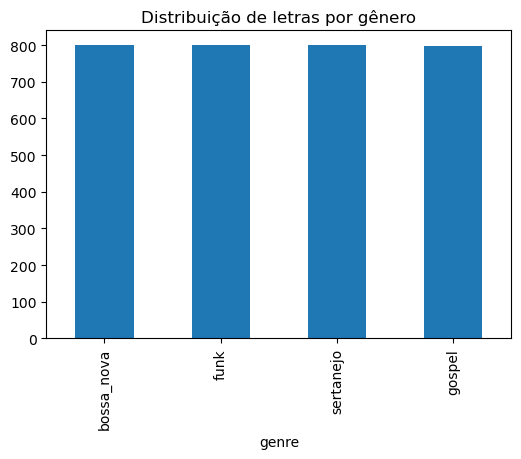

In [87]:
df["genre"].value_counts().plot(kind="bar", title="Distribuição de letras por gênero", figsize=(6,4))
plt.show()

In [88]:
df["genre"].value_counts()

genre
bossa_nova    800
funk          800
sertanejo     800
gospel        798
Name: count, dtype: int64

### Tamanho das letras

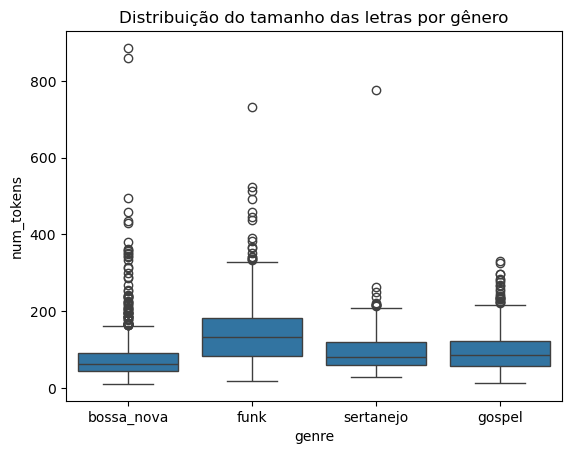

In [ ]:
sns.boxplot(data=df, x="genre", y="num_tokens")
plt.title("Distribuição do tamanho das letras por gênero")
plt.show()              

### Estatísticas sobre a quantidade de tokens

In [128]:
df[['genre','num_tokens']].groupby('genre').agg(
    min=('num_tokens', 'min'),
    max=('num_tokens', 'max'),
    mean=('num_tokens', 'mean'),
    median=('num_tokens', 'median'),
    std=('num_tokens', 'std')   
).reset_index().round(0)

,genre,min,max,mean,median,std
0,bossa_nova,11,886,82.0,62.0,74.0
1,funk,19,731,141.0,132.0,78.0
2,gospel,12,331,96.0,86.0,50.0
3,sertanejo,28,775,92.0,81.0,47.0


### Palavras mais comuns

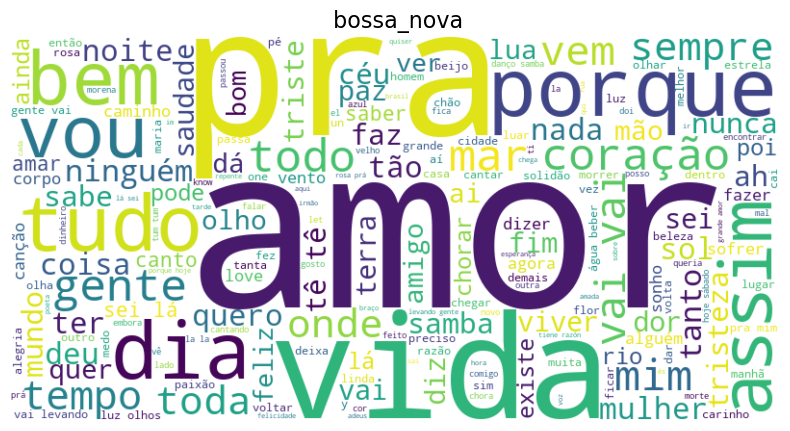

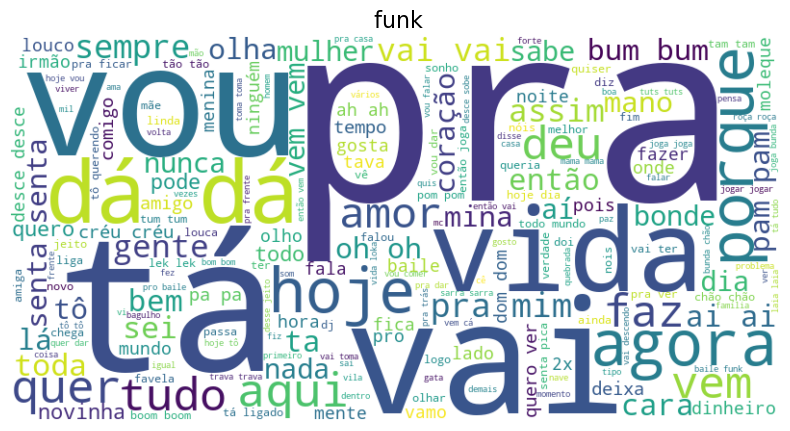

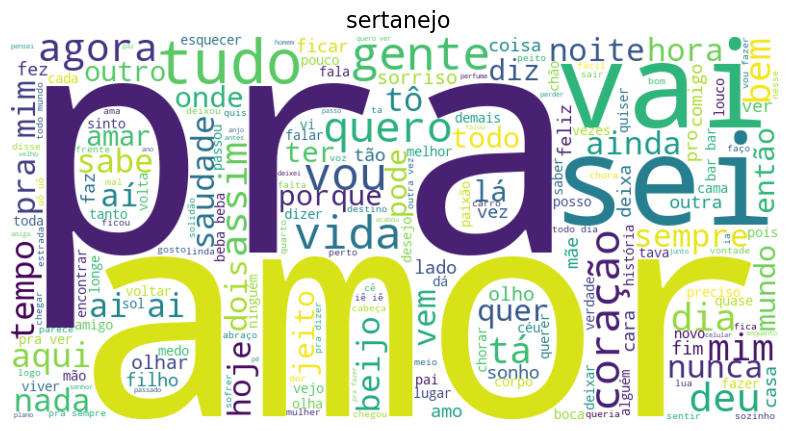

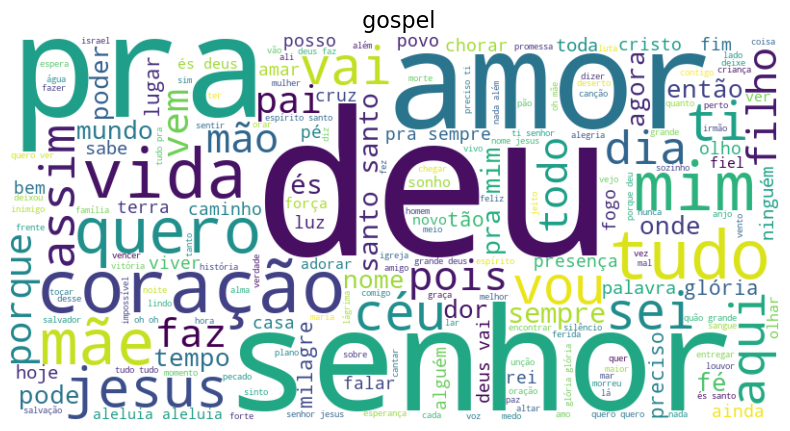

In [109]:
for genre in genres:
    text = ' '.join(df[df['genre'] == genre]['lyrics_clean'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f' {genre}', fontsize=16)
    plt.show

### Palavras únicas por gênero

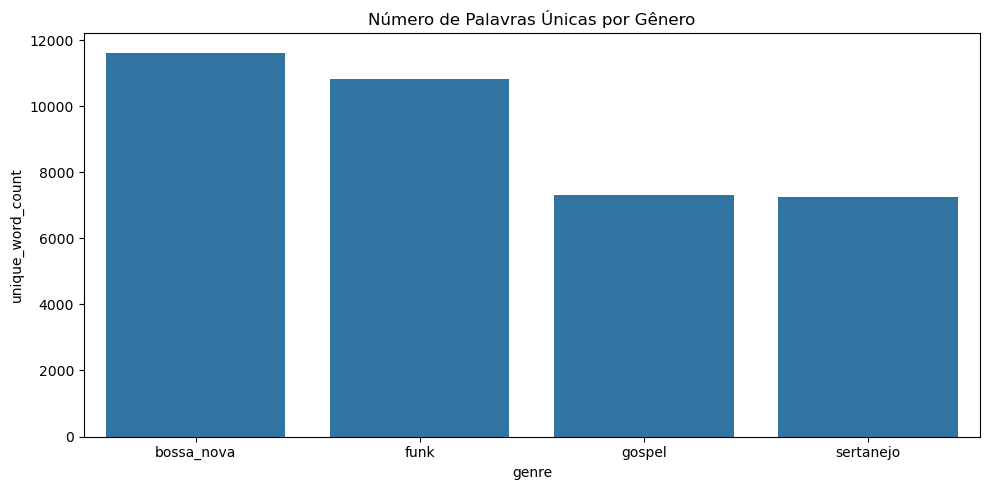

In [52]:
df['unique_tokens'] = df['lyrics_clean'].str.split().apply(set)

unique_words_by_genre = df.groupby("genre")["unique_tokens"].apply(
    lambda sets: len(set().union(*sets))
).reset_index(name="unique_word_count")

plt.figure(figsize=(10, 5))
sns.barplot(data=unique_words_by_genre, x="genre", y="unique_word_count")
plt.title("Número de Palavras Únicas por Gênero")
plt.tight_layout()
plt.show()

### Top palavras mais encontradas, por gênero

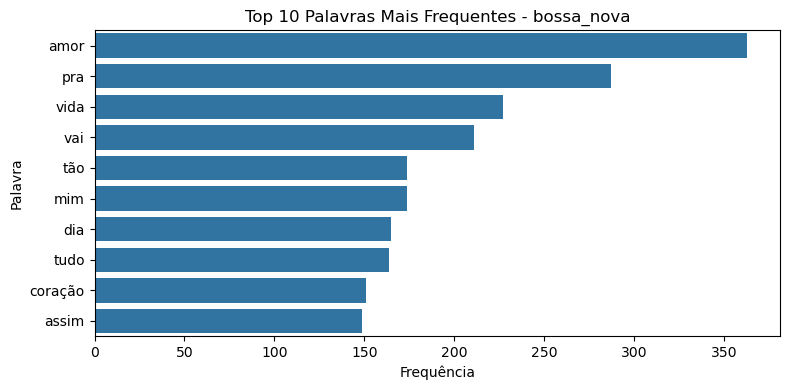

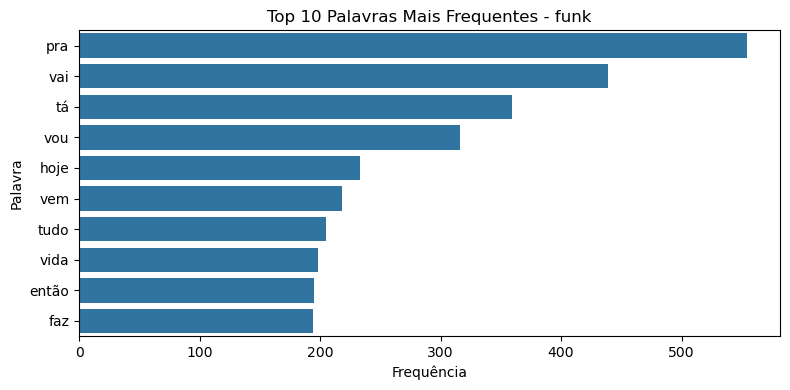

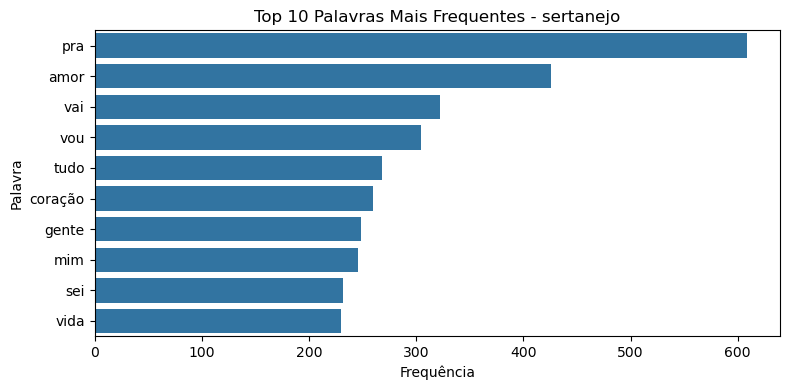

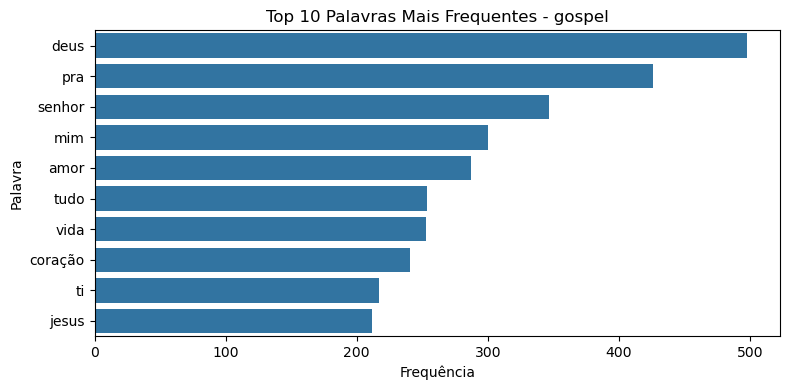

In [ ]:
top_words_by_genre = {}

for genre in df["genre"].unique():
    all_words = [word for tokens in df[df["genre"] == genre]["unique_tokens"] for word in tokens]
    common_words = Counter(all_words).most_common(10)
    top_words_by_genre[genre] = pd.DataFrame(common_words, columns=["word", "count"])

# Visualizando Top 10 por gênero
for genre, word_df in top_words_by_genre.items():
    plt.figure(figsize=(8, 4))
    sns.barplot(data=word_df, x="count", y="word")
    plt.title(f"Top 10 Palavras Mais Frequentes - {genre}")
    plt.xlabel("Frequência")
    plt.ylabel("Palavra")
    plt.tight_layout()
    plt.show()

### Distribuição do número de Tokens por gênero

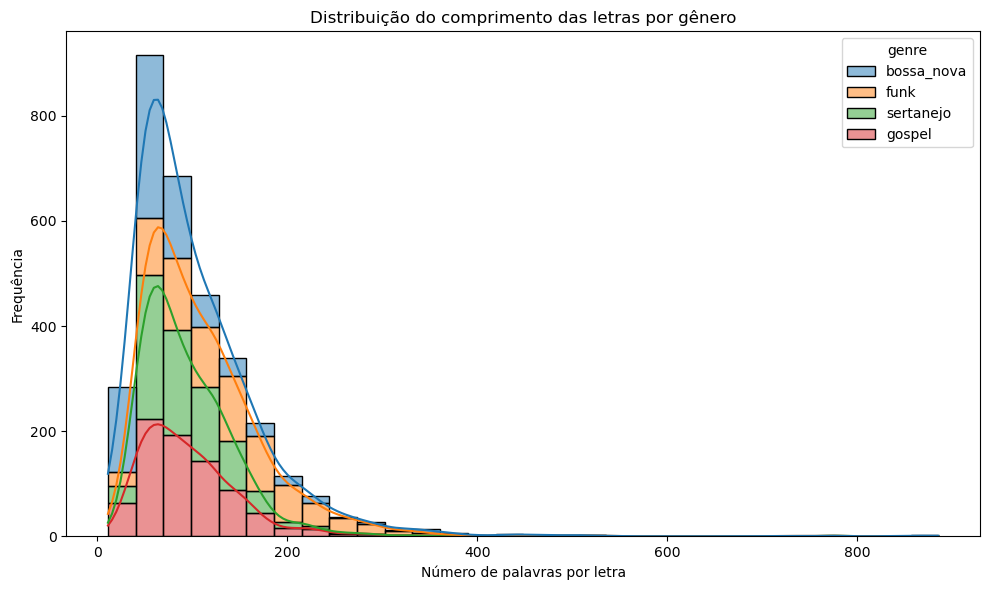

In [110]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='num_tokens', bins=30, hue='genre', kde=True, multiple='stack')
plt.title('Distribuição do comprimento das letras por gênero')
plt.xlabel('Número de palavras por letra')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()


# 5. Separação de dados

### Estratégia de treinamento:
- Separar o dataset em treino e teste (20% para teste)
- Executar pipeline de vários modelos, utilizando **TfidfVectorizer**
- Treinamento + validação cruzada com GridSearchCV para todos os modelos
- Aplicar métricas de avaliação, como Precision, Recall, F1-Score, Acurácia e matriz de confusão

In [55]:
X = df["lyrics_clean"]
y = df["genre"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [59]:
pipelines = {
    'LogisticRegression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=1000)),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    'RandomForest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=1000)),
        ('clf', RandomForestClassifier())
    ]),
    'MultinomialNB': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=1000)),
        ('clf', MultinomialNB())
    ]),
    'LinearSVC': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=1000)),
        ('clf', LinearSVC())
    ]),
}

params = {
    'LogisticRegression': {
        'clf__C': [0.1, 1, 10],
        'clf__max_iter': [100, 500, 1000]
    },
    'RandomForest': {
        'clf__n_estimators': [100, 200,500],
        'clf__max_depth': [5, 10, 20],
        'clf__min_samples_split': [2, 5, 10]
    },
    'MultinomialNB': {
        'clf__alpha': [0.01, 0.1, 1, 10]
    },
    'LinearSVC': {
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__max_iter': [1000, 2000, 5000],
        'clf__loss': ['hinge', 'squared_hinge']
    }
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}

for name in pipelines:
    print(f"\n🔍 Treinando e avaliando: {name}")
    grid = GridSearchCV(pipelines[name], params[name], cv=cv, n_jobs=-1, scoring='accuracy')
    grid.fit(X_train, y_train)
    print("✅ Melhor parâmetro:", grid.best_params_)
    print("🏆 Accuracy cross-val:", grid.best_score_)
    
    # Avaliação no teste
    y_pred = grid.predict(X_test)
    print("📊 Avaliação no conjunto de teste:")
    print(classification_report(y_test, y_pred))
    
    best_models[name] = grid.best_estimator_



🔍 Treinando e avaliando: LogisticRegression
✅ Melhor parâmetro: {'clf__C': 1, 'clf__max_iter': 100}
🏆 Accuracy cross-val: 0.8154736423679061
📊 Avaliação no conjunto de teste:
              precision    recall  f1-score   support

  bossa_nova       0.80      0.84      0.82       160
        funk       0.87      0.82      0.85       160
      gospel       0.92      0.92      0.92       160
   sertanejo       0.73      0.74      0.74       160

    accuracy                           0.83       640
   macro avg       0.83      0.83      0.83       640
weighted avg       0.83      0.83      0.83       640


🔍 Treinando e avaliando: RandomForest
✅ Melhor parâmetro: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}
🏆 Accuracy cross-val: 0.8021763392857142
📊 Avaliação no conjunto de teste:
              precision    recall  f1-score   support

  bossa_nova       0.78      0.82      0.80       160
        funk       0.90      0.76      0.82       160
      gospel  

### Escolha do melhor modelo:

In [62]:
grid.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('clf', LinearSVC(C=0.1))])

In [65]:
# Salvando o modelo em disco
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(best_models[name], f)